# Setup libraries

In [1]:
!pip install --upgrade pip
!pip uninstall -y transformers tokenizers accelerate -q
!pip install "transformers==4.56.0" "protobuf==5.29.3" -q
!pip install torch datasets -q
!pip install pandas matplotlib seaborn tqdm wandb pyyaml
!pip install bitsandbytes accelerate
# !pip install -r requirements.txt
!pip install --force-reinstall --no-cache-dir "numpy<2.0"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.18.0 requires accelerate>=0.21.0, which is not installed.
  Using cached accelerate-1.12.0-py3-none-any.whl.metadata (19 kB)
Using cached accelerate-1.12.0-py3-none-any.whl (380 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 41.5 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_versi

# Suppress warnings

In [1]:
# Suppress warnings for clean output
import warnings
import os
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"
print("✅ Packages installed successfully!")

✅ Packages installed successfully!


# Install Libraries

In [2]:
"Built-in libraries"
import re
import sys
import gc
import time
import json
import hashlib
import glob
import zipfile
from io import StringIO
from datetime import datetime
from typing import Dict, List, Optional, Tuple, Any
import yaml
import logging
import random

"Deep learning and NLP libraries"
import torch
import torch.nn.functional as F
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    GenerationConfig,
    logging as hf_logging
)

"Data processing libraries"
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from tqdm.auto import tqdm
from IPython import get_ipython

# Configure logging
logging.getLogger("ContinuousBatchingLogger").setLevel(logging.ERROR)
hf_logging.set_verbosity_error()


print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
!nvidia-smi

Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch Version: 2.9.0+cu126
CUDA Available: True
CUDA Version: 12.6
Sun Dec 21 17:45:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|   

In [3]:
import os
def configure_environment_paths():
    """Detect environment and configure paths"""
    try:
        if "google.colab" in str(get_ipython()):
            print("✅ Environment: Google Colab")
            base_data_path = "/content/"
            base_output_path = "/content/"
            environment_name = "colab"
        elif os.environ.get("KAGGLE_KERNEL_RUN_TYPE"):
            print("✅ Environment: Kaggle")
            base_data_path = "/kaggle/input/"
            base_output_path = "/kaggle/working/"
            environment_name = "kaggle"
        else:
            print("⚠️ Environment: Local/Unknown")
            base_data_path = "./data/"
            base_output_path = "./output/"
            environment_name = "local"
    except NameError:
        print("⚠️ Non-interactive session. Using local paths.")
        base_data_path = "./data/"
        base_output_path = "./output/"
        environment_name = "local"

    os.makedirs(base_output_path, exist_ok=True)
    print(f"📂 Data Path: {base_data_path}")
    print(f"📦 Output Path: {base_output_path}")

    return base_data_path, base_output_path, environment_name

INPUT_PATH, OUTPUT_PATH, ENV_NAME = configure_environment_paths()

✅ Environment: Google Colab
📂 Data Path: /content/
📦 Output Path: /content/


# Setup WANDB

In [4]:
import os
import wandb

if "colab" in ENV_NAME:
    from google.colab import userdata
    try:
        # Ensure 'WANDB_API_KEY' is the exact name in your Colab Secrets (the key icon)
        wandb_key = userdata.get('WANDB_API_KEY')
        wandb.login(key=wandb_key)
    except Exception as e:
        print(f"Could not retrieve W&B API key from Colab Secrets: {e}")

# 2. Check if running in Kaggle
elif "kaggle" in ENV_NAME:
    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        wandb_key = user_secrets.get_secret("WANDB_API_KEY")
        wandb.login(key=wandb_key)
    except Exception as e:
        print(f"Could not retrieve W&B API key from Kaggle Secrets: {e}")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dungngocpham171 (dungngocpham171-university-of-science) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Config input/output path and clone latest repo

In [5]:
# Clone the latest github repo version
%cd {OUTPUT_PATH}
torch.cuda.empty_cache()
!rm -rf OuroTrace

/content


In [6]:
!git clone --branch claude https://github.com/dzungphieuluuky/OuroTrace.git
%cd OuroTrace

Cloning into 'OuroTrace'...
remote: Enumerating objects: 1538, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 1538 (delta 10), reused 16 (delta 7), pack-reused 1518 (from 2)
Receiving objects: 100% (1538/1538), 1.97 MiB | 4.97 MiB/s, done.
Resolving deltas: 100% (995/995), done.
/content/OuroTrace


# Run Benchmark

In [17]:
import pandas as pd
from src.config_loader import load_config_from_json, post_process_config

# this is the fused version when single and batch use the same predict function
from src.new_runner import run_batch_experiment

# this is the original version when single and batch use different functions
# from src.runner import run_batch_experiment

from src.evaluation import analyze_experiment_results


# 1. Load Configuration from JSON
config = load_config_from_json('configs/batch_ouro_1.4b_thinking.json')

# 2. Post-process (Convert 'torch.float16' string to object, generate timestamps)
config = post_process_config(config)

config["INFERENCE_STEPS"] = [4]
# config["DATA"]["n_ary"]["num_samples_per_level"] = 0
# config["DATA"]["p_hop"]["num_samples_per_level"] = 0
# config["DATA"]["igsm"]["num_samples_per_level"] = 0
# 4. Execute
print("🚀 Starting Experiment...")
try:
    del model, tokenizer
    torch.cuda.empty_cache()
    gc.collect()
except:
    pass

try:
  acc_results, ppl_results, hol_results = run_batch_experiment(config)
except Exception as e:
  print(f"An unexpected error occurred: {e}")

🚀 Starting Experiment...
🔗 Initializing W&B (timeout: 30s)...


perplexity,▁
ut_steps,▁
val_loss,▁
perplexity,0.46758
ut_steps,4
val_loss,1.59613


✅ W&B initialized

🔧 EXPERIMENT CONFIGURATION
Model Path: ByteDance/Ouro-1.4B-Thinking
UT Steps to Test: [4]
Data Type: torch.bfloat16
4-bit Quantization: False
Torch Compile: False
Max Batch Size: 12
Max New Tokens: 512
Batching: True
Calculate Perplexity: True
Early Exit: 1.0

[+] Quality monitor initialized:
    → Garbage threshold: 30%
    → Example similarity threshold: 85%
    → Min samples before check: 10
🎲 Random seed set to 42

📦 LOADING TEST DATASETS
⚙️ Generating new test datasets...
✅ Generated test datasets

Dataset Summary:
   n_ary       :    0 samples
   p_hop       :    0 samples
   igsm        :  100 samples


📋 PAPER COMPLIANCE CHECK
Task Alignment: {'has_n_ary': True, 'has_p_hop': True, 'has_igsm': True, 'all_paper_tasks': True}
UT Steps Coverage: {'min_ut': 4, 'max_ut': 4, 'covers_baseline': False, 'covers_paper_range': False, 'recommended_range': [1, 2, 4, 8]}

📚 Preparing perplexity evaluation data...
✅ Prepared 50 samples for PPL

✅ Configuration saved to ./res

Calculating PPL (UT=4):   0%|          | 0/8 [00:00<?, ?it/s]


✅ Perplexity Results:
   Perplexity: 0.4409
   Avg Loss:   1.5541

🎯 ACCURACY EVALUATION

⚠️ Skipping n_ary - no test items

⚠️ Skipping p_hop - no test items


──────────────────────────────────────────────────────────────────────
📝 Task: IGSM
──────────────────────────────────────────────────────────────────────
Total Samples: 100
Batch Size: 2
Strategy: Batched Processing

Running 50 batches...


   igsm:   0%|          | 0/50 [00:00<?, ?it/s]

                                          test_input     full_response  \
0  Question. J#A := 1. K#L := L#A. G#G := J#N * L...  [FINAL]  2 [END]   

   generated_tokens  
0                 5  
                                          test_input     full_response  \
0  Question. C#L := A#M. A#O := N#L * N#L. N#D :=...  [FINAL]  2 [END]   

   generated_tokens  
0                 5  
                                          test_input     full_response  \
0  Question. C#B := G#B. C#M := D#G. K#D := G#B. ...  [FINAL]  6 [END]   

   generated_tokens  
0                 5  
                                          test_input     full_response  \
0  Question. A#O := C#C. I#E := 3. J#N := E#F. E#...  [FINAL]  2 [END]   

   generated_tokens  
0                 5  
                                          test_input     full_response  \
0  Question. L#N := 3. I#K := F#N + F#N. I#E := F...  [FINAL]  2 [END]   

   generated_tokens  
0                 5  
                                   

In [20]:
import os
import glob
import zipfile
from typing import List


def find_result_folders(base_path: str) -> List[str]:
    """
    Return a list of absolute paths to all directories under `base_path`
    whose names start with 'results_'.
    """
    pattern = os.path.join(base_path, "results_*")
    # glob returns both files and directories; filter to directories only
    return [p for p in glob.glob(pattern) if os.path.isdir(p)]


def zip_folder(folder_path: str, output_base_path: str) -> bool:
    """
    Zip the contents of `folder_path` into a file named
    <folder_name>.zip` inside `output_base_path`.

    Returns True on success, False otherwise.
    """
    folder_name = os.path.basename(folder_path)
    zip_path = os.path.join(output_base_path, f"{folder_name}.zip")

    try:
        print(f"   -> Zipping folder: {folder_name}...")
        with zipfile.ZipFile(zip_path, mode="w", compression=zipfile.ZIP_DEFLATED) as zipf:
            for root, _, files in os.walk(folder_path):
                for file in files:
                    full_path = os.path.join(root, file)
                    # Preserve relative path inside the zip
                    arcname = os.path.relpath(full_path, os.path.dirname(folder_path))
                    zipf.write(full_path, arcname)
        print(f"   ✅ Created ZIP: {os.path.basename(zip_path)}")
        return True
    except Exception as exc:
        print(f"   ❌ Failed to zip {folder_name}: {exc}")
        return False


def zip_all_results_folders(output_base_path: str) -> None:
    """
    Main driver: locate all result folders and zip each one.
    """
    # Ensure the output directory exists
    os.makedirs(output_base_path, exist_ok=True)

    result_folders = find_result_folders(output_base_path)

    if not result_folders:
        print(f"⚠️ No folders starting with 'results_' found in '{output_base_path}'.")
        return

    print(f"🔍 Found {len(result_folders)} result folder(s) to zip.")
    successful = 0

    for folder in result_folders:
        if zip_folder(folder, output_base_path):
            successful += 1

    print(f"\n✅ DONE! Successfully zipped {successful} out of {len(result_folders)} folder(s).")

if __name__ == "__main__":
    try:
        # Prefer an environment variable; fall back to a global if defined
        output_root = os.getenv("OUTPUT_PATH") or globals().get("OUTPUT_PATH")
        if not output_root:
            raise ValueError("OUTPUT_PATH not defined")

        # The script expects a sub‑folder named 'OuroTrace' under OUTPUT_PATH
        target_path = os.path.join(output_root, "OuroTrace")
        zip_all_results_folders(target_path)

    except Exception as e:
        print(f"❌ An error occurred: {e}")

🔍 Found 3 result folder(s) to zip.
   -> Zipping folder: results_20251221_174510...
   ✅ Created ZIP: results_20251221_174510.zip
   -> Zipping folder: results_20251221_175606...
   ✅ Created ZIP: results_20251221_175606.zip
   -> Zipping folder: results_20251221_174732...
   ✅ Created ZIP: results_20251221_174732.zip

✅ DONE! Successfully zipped 3 out of 3 folder(s).



📊 VISUALIZATION

--- Summary Statistics ---
                    is_correct_mean  is_correct_count  is_correct_std  \
ut_steps task_type                                                      
4        p_hop                0.226                31           0.425   

                    generation_time_mean  generation_time_min  \
ut_steps task_type                                              
4        p_hop                    31.683                  0.0   

                    generation_time_max  generated_tokens_mean  
ut_steps task_type                                              
4        p_hop                   45.171                  4.226  


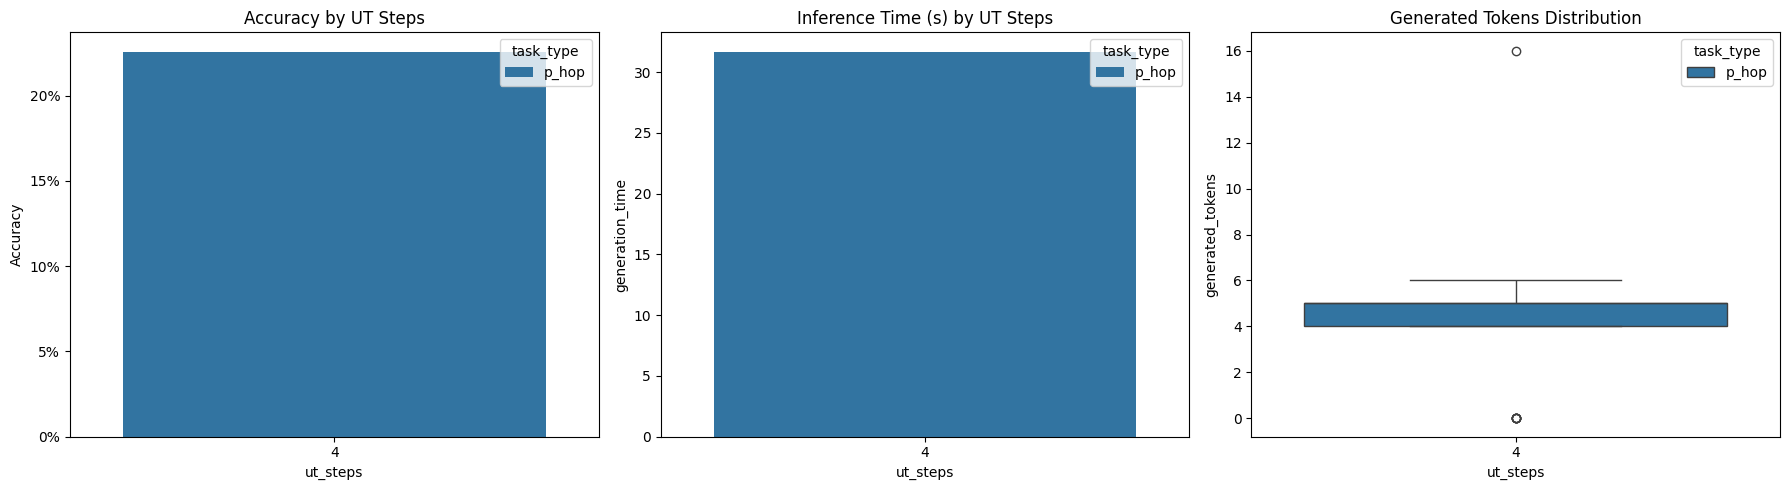


🏁 Experiment Complete.



In [14]:
# 3. Save Results
df_acc = pd.DataFrame(acc_results)
df_ppl = pd.DataFrame(ppl_results)
df_hol = pd.DataFrame(hol_results)
# 4. Visualization & Reporting
if not df_acc.empty:
    print("\n" + "="*50 + "\n📊 VISUALIZATION\n" + "="*50)

    # Summary Tables
    # NOTE: The variable 'results_acc' is used here, assuming it holds the raw data
    # (list of dicts) required by 'analyze_experiment_results'.
    summary = analyze_experiment_results(acc_results)
    print("\n--- Summary Statistics ---")
    print(summary)

    # Plotting
    try:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Plot 1: Accuracy
        acc_summary = df_acc.groupby(['task_type', 'ut_steps'])['is_correct'].mean().reset_index()
        sns.barplot(data=acc_summary, x='ut_steps', y='is_correct', hue='task_type', ax=axes[0])
        axes[0].set_title('Accuracy by UT Steps')
        axes[0].set_ylabel('Accuracy')
        axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

        # Plot 2: Time
        time_summary = df_acc.groupby(['task_type', 'ut_steps'])['generation_time'].mean().reset_index()
        sns.barplot(data=time_summary, x='ut_steps', y='generation_time', hue='task_type', ax=axes[1])
        axes[1].set_title('Inference Time (s) by UT Steps')

        # Plot 3: Token Count
        sns.boxplot(data=df_acc, x='ut_steps', y='generated_tokens', hue='task_type', ax=axes[2])
        axes[2].set_title('Generated Tokens Distribution')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Visualization error: {e}")
else:
    print("⚠️ No results to visualize.")

print("\n🏁 Experiment Complete.\n")

In [15]:
print("Final Inspection:\n")
print("Top 20 Accuracy Report:\n")
print(df_acc.head(20))
print(f"Full Response:\n")
print(df_acc['full_response'])
print("Perplexity Report:\n")
print(df_ppl.head(20))

Final Inspection:

Top 20 Accuracy Report:

   task_type difficulty                                         test_input  \
0      p_hop    16_hops  Sequence: B B B C C A B C D B D D D C A B B D ...   
1      p_hop    16_hops  Sequence: B D D B C D A B A B B B C C A C B C ...   
2      p_hop    16_hops  Sequence: D D A D A C D D D A C B A B B D A B ...   
3      p_hop    16_hops  Sequence: D A D A C C D D B D B D B A B C A B ...   
4      p_hop    16_hops  Sequence: A B A B B D D C C C C C D D C C A C ...   
5      p_hop    16_hops  Sequence: A B D D B D B A A D A B B B C B A D ...   
6      p_hop    16_hops  Sequence: C B D C D D C A A C D D C C A B C B ...   
7      p_hop    16_hops  Sequence: A B A C A B D A C D B D C C A C D C ...   
8      p_hop    16_hops  Sequence: D C B C C B B C C C D A C A B D A A ...   
9      p_hop    16_hops  Sequence: B B A A A D B C C C A C D B D B B B ...   
10     p_hop    16_hops  Sequence: A B C B C C A A D B A D C D B B B C ...   
11     p_hop    16_h

In [16]:
print(df_acc[['full_response', 'generated_tokens']])

                             full_response  generated_tokens
0                         [FINAL]  D [END]                 4
1                    [FINAL]  D\n\n**Final                 5
2                         [FINAL]  D [END]                 4
3                         [FINAL]  D [END]                 4
4                    [FINAL]  D\n\n**Final                 5
5                      [FINAL] \n\n**Final                 4
6                    [FINAL]  A\n\n**Final                 5
7                    [FINAL]  D\n\n**Final                 5
8                    [FINAL]  D\n\n**Final                 5
9                    [FINAL]  D\n\n**Final                 5
10                     [FINAL]  D\n\n[END]                 6
11                   [FINAL]  D\n\n**Final                 5
12                   [FINAL]  D\n\n**Final                 5
13                   [FINAL]  D\n\n**Final                 5
14                   [FINAL]  D\n\n**Final                 5
15  [FINAL]  D\n\n[FINAL